<a href="https://colab.research.google.com/github/HeadOutii/AIRepair/blob/main/Resnet07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy pandas matplotlib opencv-python kaggle

In [ ]:
# Импорт необходимых библиотек
import kagglehub
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [ ]:
path = kagglehub.dataset_download("bharatadhikari/humanface8000")
print("Path to dataset files:", path)
image_folder = os.path.join(path, 'landscape Images/gray')
mask_folder = os.path.join(path, 'landscape Images/color')

100%|██████████| 475M/475M [00:02<00:00, 191MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bharatadhikari/humanface8000/versions/1


In [ ]:
IMAGE_SIZE = (128, 128)
NUM_IMAGES = 8000
BATCH_SIZE = 32
EPOCHS = 40

In [ ]:
# ЗАгрузка изображений из папки
def load_images(folder, num_images, target_size):

    images = []
    for filename in os.listdir(folder)[:num_images]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

In [ ]:
# Загрузка набора данных
gray_images = load_images(os.path.join(image_folder), NUM_IMAGES, IMAGE_SIZE)
color_images = load_images(os.path.join(mask_folder), NUM_IMAGES, IMAGE_SIZE)

In [ ]:
# Нормализация
gray_images = gray_images.astype('float32') / 255.0
color_images = color_images.astype('float32') / 255.0

In [ ]:
# Разделение набора данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.2, random_state=42)

In [ ]:
def residual_block(x, filters):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def create_resnet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=1, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(5):
        x = residual_block(x, 64)

    # Дополнительные слои для выхода
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(3, (1, 1), padding='same', activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

model = create_resnet_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Обучнений модели
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test)
)

Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 351ms/step - loss: 0.0383 - val_loss: 0.0096
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 330ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 336ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 336ms/step - loss: 0.0204 - val_loss: 0.0065
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 343ms/step - loss: 0.0067 - val_loss: 0.0055
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 65s 327ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 336ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 329ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 9/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 328ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 10/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 342ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 11/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 349ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 12/40
200/200

In [ ]:
# Сохранение модели
model.save('image_restoration_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


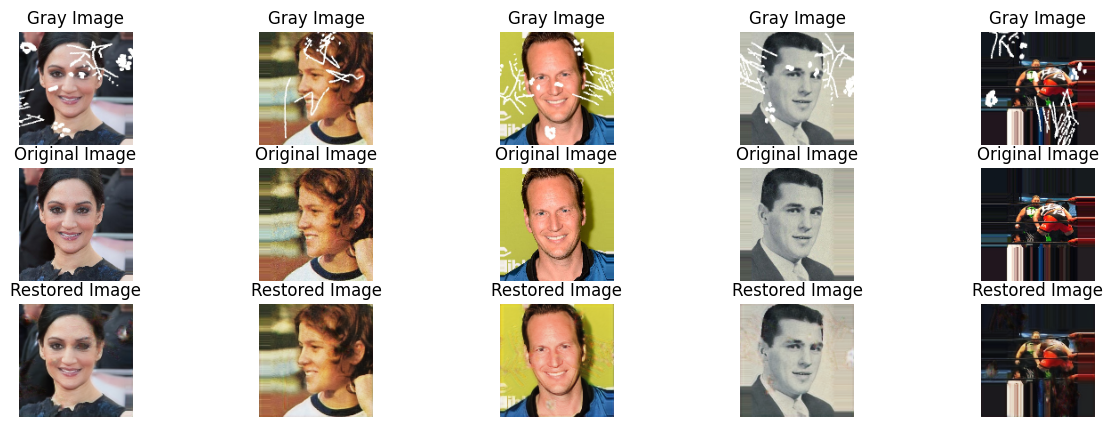

In [ ]:
# Визуализация
def visualize_results(X_test, y_test, model, num_images=5):

    preds = model.predict(X_test[:num_images])

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title("Поврежденное")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(y_test[i])
        plt.title("Оригинал")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(preds[i])
        plt.title("Восстановленное")
        plt.axis('off')

    plt.show()

visualize_results(X_test, y_test, model)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, 1)

# MSE
mse = np.mean((y_test - y_pred) ** 2)
# MAE
mae = np.mean(np.abs(y_test - y_pred))
# RMSE
rmse = np.sqrt(mse)
# PSNR
psnr = tf.image.psnr(y_test, y_pred, max_val=1.0)
mean_psnr = tf.reduce_mean(psnr).numpy()
# SSIM
ssim = tf.image.ssim(y_test, y_pred, max_val=1.0)
mean_ssim = tf.reduce_mean(ssim).numpy()

# Вывод метрик
print(f"📊 MSE:  {mse:.5f}")
print(f"📊 MAE:  {mae:.5f}")
print(f"📊 RMSE: {rmse:.5f}")
print(f"📊 PSNR: {mean_psnr:.2f} dB")
print(f"📊 SSIM: {mean_ssim:.5f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step
📊 MSE:  0.00355
📊 MAE:  0.03467
📊 RMSE: 0.05955
📊 PSNR: 25.24 dB
📊 SSIM: 0.82682
